# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
df = pd.read_excel('geo.xlsx')

In [3]:
df.head()

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108806 entries, 0 to 108805
Data columns (total 3 columns):
x                108806 non-null float64
y                108806 non-null float64
comment_class    108806 non-null int64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB


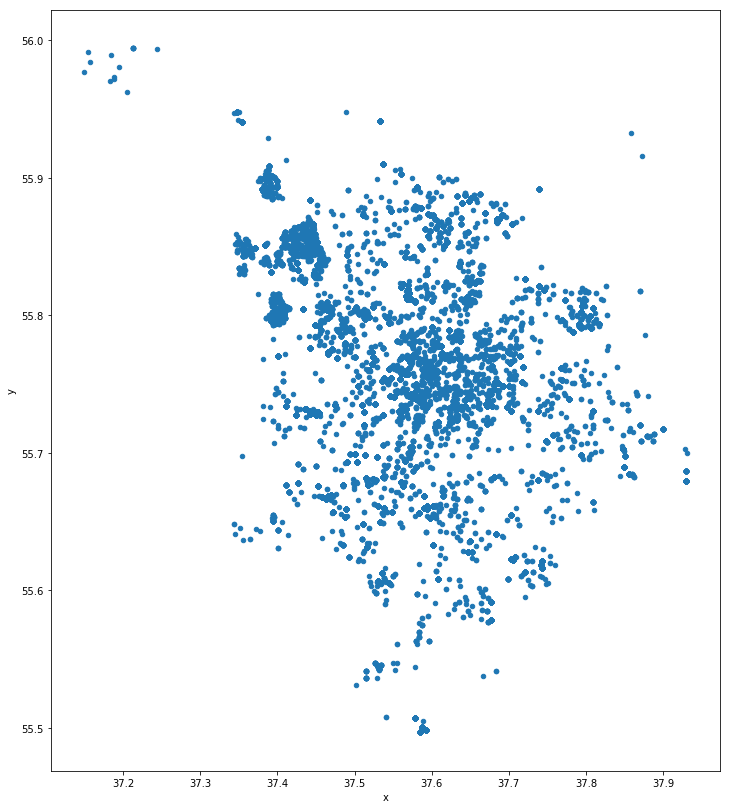

In [15]:
df.plot(x='x', y= 'y', kind='scatter', figsize=(12, 14))

контуры москвы угадываются, попробуем сделать кластеризацию согласно делению на административные округа. здесь похоже, что схема делалась без учёта "новой москвы", поэтому возьмём 9 округов + зеленоград, итого 10 кластеров

сделаем кластеризацию несколькими способами

In [16]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [17]:
algorithms = [
    AffinityPropagation(),
    KMeans(n_clusters=10),
    AgglomerativeClustering(n_clusters=10),
    DBSCAN(),
]

К сожалению построить кластеризацию сразу по всем алгоритмам не получилось (нехватка памяти), попробуем по одному

In [23]:
coord = df[['x','y']]

In [35]:
#в качестве эксперимента проверим, изменится ли результат кластеризации, если отшкалировать наши координаты
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
coord_scaled = scaler.fit_transform(coord)

Сначала попробуем алгоритм KMeans (на шкалированных и не шкалированных координатах)

In [64]:
clust_kmean = KMeans(n_clusters=10).fit_predict(coord)
clust_kmean_scaled = KMeans(n_clusters=10).fit_predict(coord_scaled)

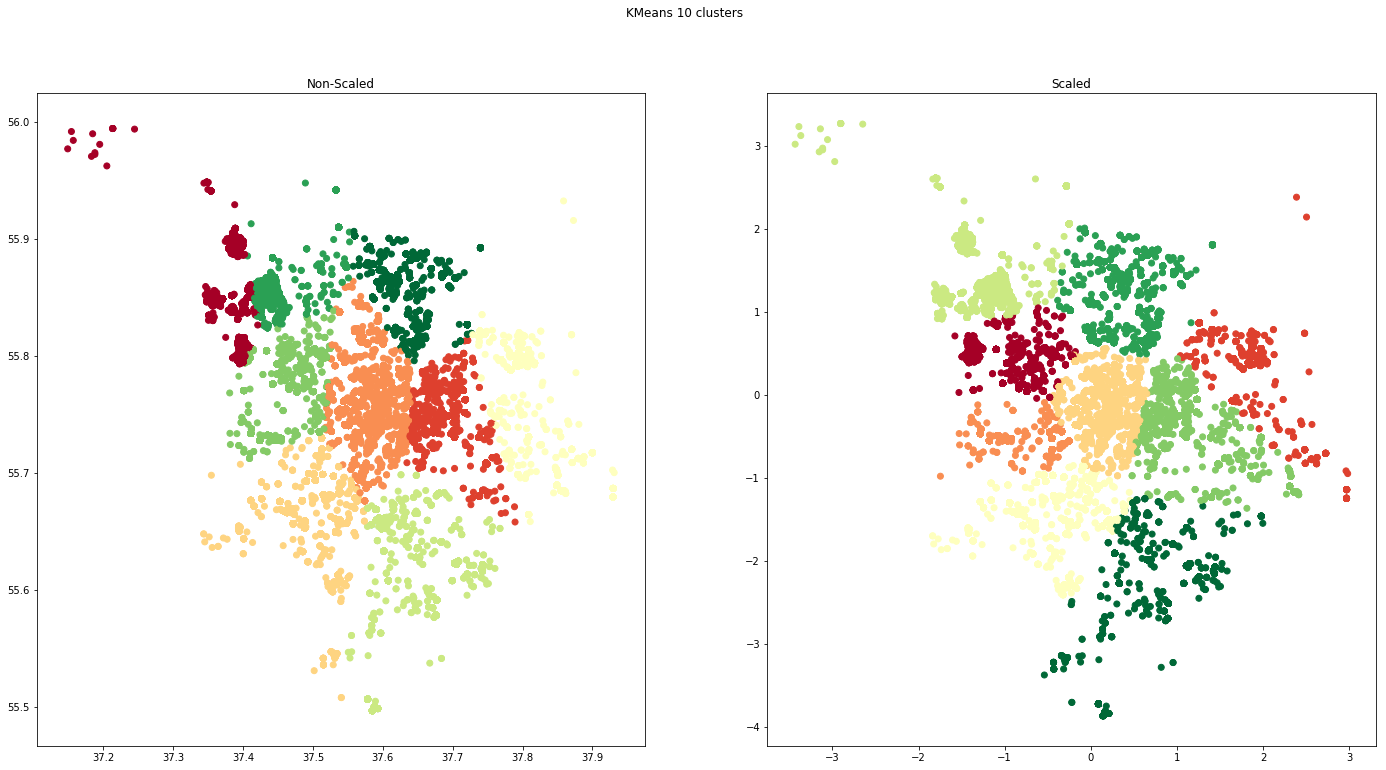

In [57]:
#визуализируем в одном пространстве
plt.figure(figsize=(24, 12))
plt.suptitle('KMeans 10 clusters')
plt.subplot(1,2,1)
plt.title('Non-Scaled')
plt.scatter(coord['x'], coord['y'],  c = clust_kmean, cmap = 'RdYlGn')

plt.subplot(1,2,2)
plt.title('Scaled')
plt.scatter(coord_scaled[:,0], coord_scaled[:,1],  c = clust_kmean_scaled, cmap = 'RdYlGn')
plt.show()

отшкалированные координаты показывают большую близость к реальным очертаниям АО Москвы. Попробуем построить на примере 9 кластеров, т.к. Зеленоград в данном алгоритме очевидно "отказывается" быть отдельным АО.

In [51]:
clust_kmean = KMeans(n_clusters=9).fit_predict(coord)
clust_kmean_scaled = KMeans(n_clusters=9).fit_predict(coord_scaled)

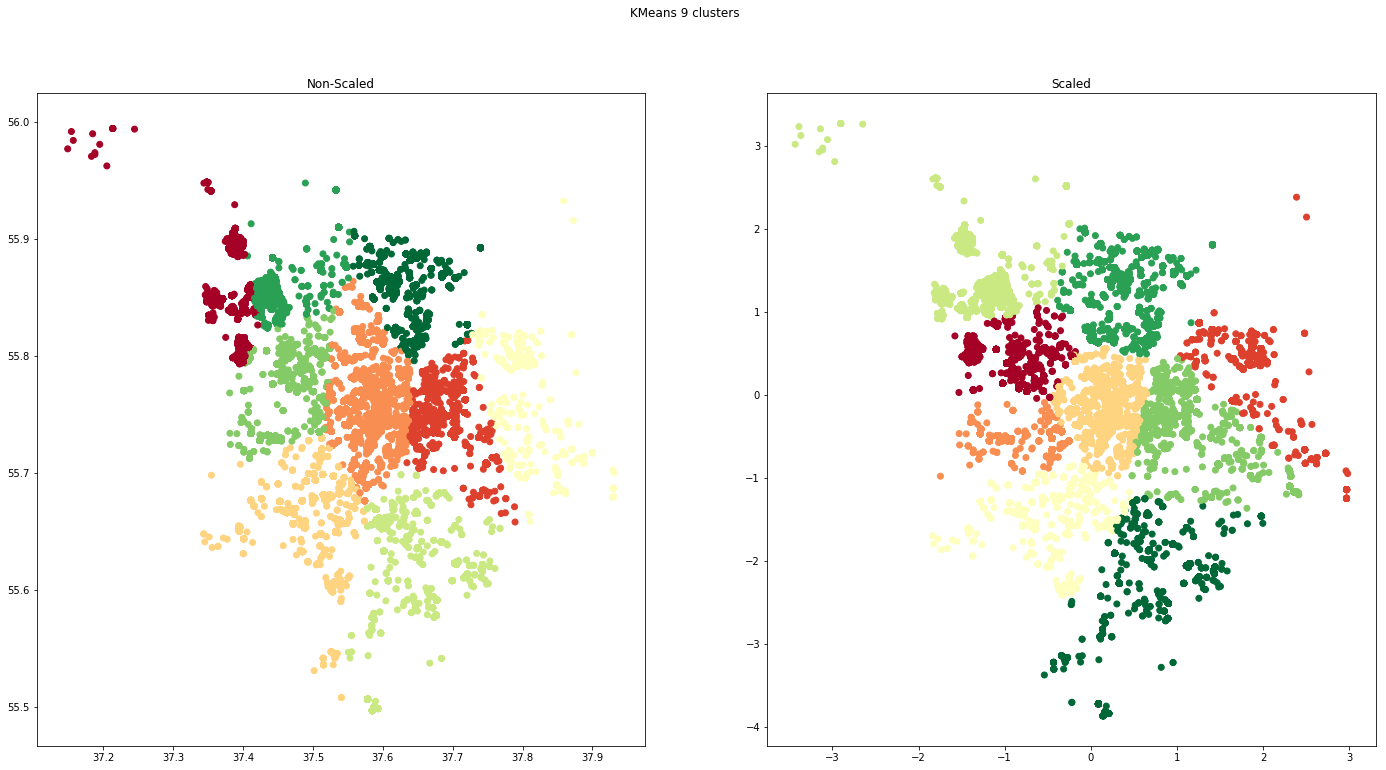

In [55]:
#визуализируем в одном пространстве
plt.figure(figsize=(24, 12))
plt.suptitle('KMeans 9 clusters')
plt.subplot(1,2,1)
plt.title('Non-Scaled')
plt.scatter(coord['x'], coord['y'],  c = clust_kmean, cmap = 'RdYlGn')

plt.subplot(1,2,2)
plt.title('Scaled')
plt.scatter(coord_scaled[:,0], coord_scaled[:,1],  c = clust_kmean_scaled, cmap = 'RdYlGn')
plt.show()

Попробуем подобрать оптимальное количество кластеров алгоритмически

In [69]:
k_inertia = []
ks = range(4,20)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(coord_scaled, )
    k_inertia.append(clf_kmeans.inertia_)

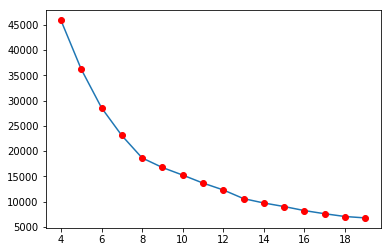

In [70]:
plt.plot(ks, k_inertia)
plt.plot(ks, k_inertia ,'ro')

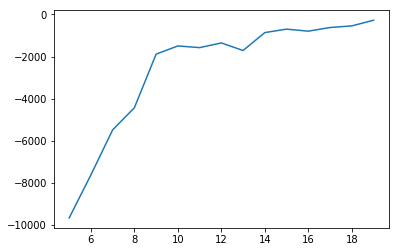

In [71]:
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

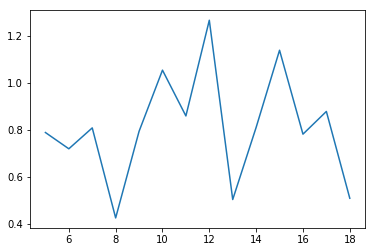

In [72]:
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)

In [73]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

8

Почти угадали :). С алгоритмической точки зрения оптимальное количество кластеров - 8. Сделаем кластеризацию

In [74]:
clust_kmean = KMeans(n_clusters=9).fit_predict(coord)
clust_kmean_scaled = KMeans(n_clusters=9).fit_predict(coord_scaled)

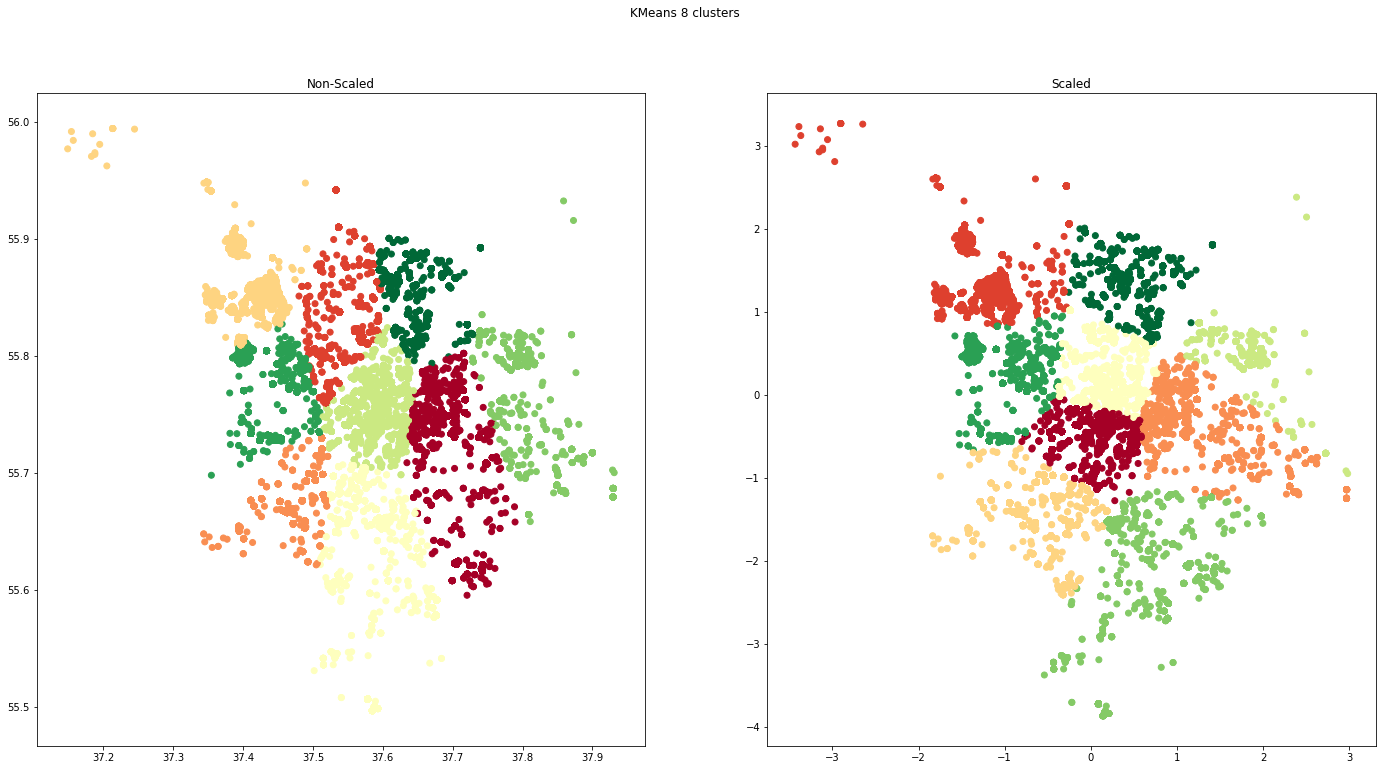

In [75]:
#визуализируем в одном пространстве
plt.figure(figsize=(24, 12))
plt.suptitle('KMeans 8 clusters')
plt.subplot(1,2,1)
plt.title('Non-Scaled')
plt.scatter(coord['x'], coord['y'],  c = clust_kmean, cmap = 'RdYlGn')

plt.subplot(1,2,2)
plt.title('Scaled')
plt.scatter(coord_scaled[:,0], coord_scaled[:,1],  c = clust_kmean_scaled, cmap = 'RdYlGn')
plt.show()

### Сравним с другими алгоритмами

пока ни один не удалось запустить из-за ошибки Memory Error

#### AgglomerativeClustering
так и не удалось запустить из-за ошибки памяти

In [62]:
#clust_aggl = AgglomerativeClustering(n_clusters=5).fit_predict(coord)
#clust_aggl_scaled = AgglomerativeClustering(n_clusters=5).fit_predict(coord_scaled)

#### AffinityPropagation

In [65]:
#clust_aff = AffinityPropagation().fit_predict(coord)
#clust_aff = AffinityPropagation().fit_predict(coord_scaled)

#### DBSCAN

In [68]:
#clust_dbscan = DBSCAN().fit_predict(coord)
#clust_dbscan = DBSCAN().fit_predict(coord_scaled)

MemoryError: 

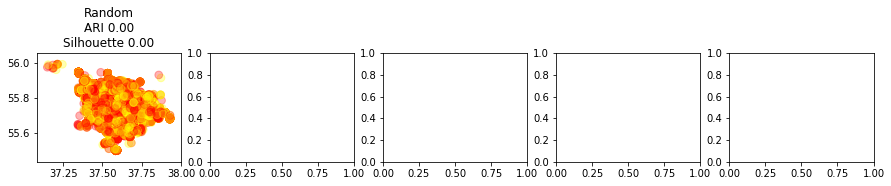

In [28]:
fig, axes = plt.subplots(1, 5, figsize=(15, 2))
alpha = 0.3
axes[0].scatter(coord['x'], coord['y'], c=clusters_random, cmap='autumn', s=60, alpha=alpha)
axes[0].set_title(get_descr("Random", coord['y'], clusters_random, coord))
for ax, algorithm in zip(axes[1:], algorithms):
    # кластеризуем и выводим картинку
    clusters = algorithm.fit_predict(coord)
    ax.scatter(coord['x'], coord['y'], c=clusters, cmap='autumn', s=60, alpha=alpha)
    ax.set_title(get_descr(algorithm.__class__.__name__, y, clusters, coord))
    
    # если есть центры кластеров - выведем их
    if algorithm.__class__.__name__ in {'KMeans', 'AffinityPropagation'}:
        centers = algorithm.cluster_centers_
        ax.scatter(centers[:, 0], centers[:, 1], s=50)